<a href="https://colab.research.google.com/github/royleekiat/hdbpricer/blob/main/hdbpricer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HDB Resale Price Prediction

Some inspiration (and code) taken from US Housing data prediction https://towardsdatascience.com/house-prices-prediction-using-deep-learning-dea265cc3154

**Dataset for HDB Resale prices**
https://data.gov.sg/dataset/resale-flat-prices

In [1]:
%pip -q install tf-nightly

     |████████████████████████████████| 453.8MB 40kB/s 
     |████████████████████████████████| 471kB 38.2MB/s 
     |████████████████████████████████| 1.2MB 38.5MB/s 
     |████████████████████████████████| 4.0MB 34.2MB/s 
     |████████████████████████████████| 6.0MB 31.6MB/s 
     |████████████████████████████████| 4.0MB 33.1MB/s 
     |████████████████████████████████| 3.9MB 28.1MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import math
import tensorflow as tf
from collections import defaultdict
import numpy as np
from numpy import unique
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, TensorBoard

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
tf.__version__

'2.6.0-dev20210402'

# Read data

In [4]:
#Dataset from https://data.gov.sg/dataset/resale-flat-prices
file_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vR50CCGJhN8H2ySdGzxXvRJkMB0mRnvo2CGBHSotmnNDMWWeyx63GGBUA1AZOLc6Yp-mao568usSYXv/pub?gid=387708077&single=true&output=csv"
data = pd.read_csv(file_url)



In [5]:
dataframe = data.copy()
dataframe.shape

(94903, 11)

In [6]:
dataframe.head()

month        town  ...     remaining_lease resale_price
0  2017-01  ANG MO KIO  ...  61 years 04 months     232000.0
1  2017-01  ANG MO KIO  ...  60 years 07 months     250000.0
2  2017-01  ANG MO KIO  ...  62 years 05 months     262000.0
3  2017-01  ANG MO KIO  ...   62 years 01 month     265000.0
4  2017-01  ANG MO KIO  ...  62 years 05 months     265000.0

[5 rows x 11 columns]

# Visualize data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local

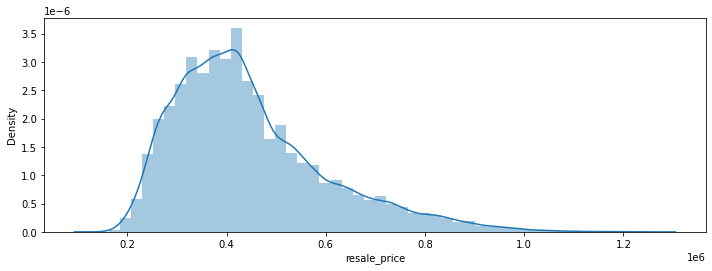

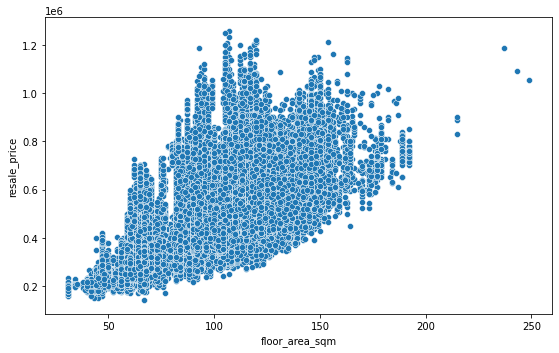

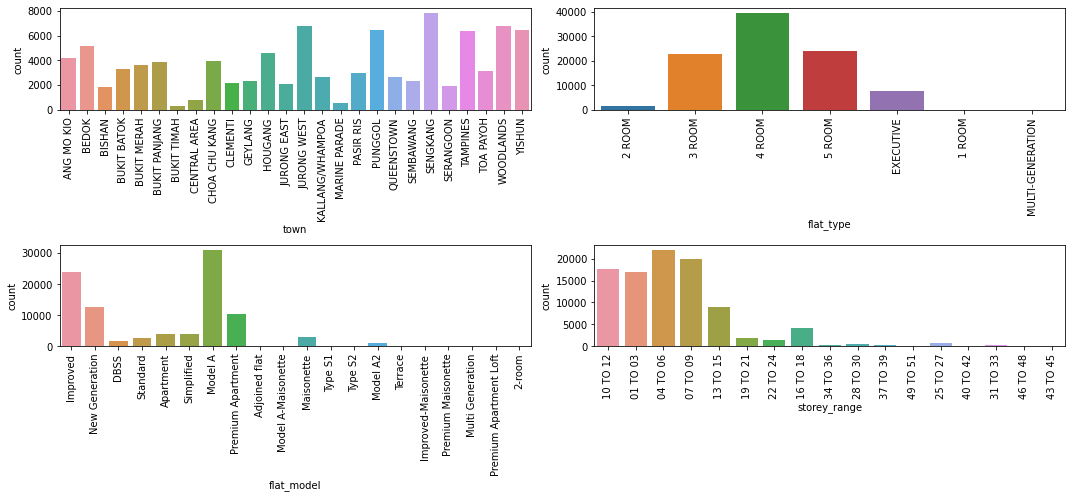

In [7]:
#visualizing house prices
fig = plt.figure(figsize=(10,7))
fig.add_subplot(2,1,1)
sns.distplot(dataframe['resale_price'])
plt.tight_layout()

#visualizing square metres
fig = plt.figure(figsize=(20,12))
fig.add_subplot(2,2,1)
sns.scatterplot(dataframe['floor_area_sqm'], dataframe['resale_price'])


#visualizing bedrooms,bathrooms,floors,grade
fig = plt.figure(figsize=(15,7))
fig.add_subplot(2,2,1)
sns.countplot(dataframe['town'])
plt.xticks(rotation=90)
fig.add_subplot(2,2,2)
sns.countplot(dataframe['flat_type'])
plt.xticks(rotation=90)
fig.add_subplot(2,2,3)
sns.countplot(dataframe['flat_model'])
plt.xticks(rotation=90)
fig.add_subplot(2,2,4)
sns.countplot(dataframe['storey_range'])
plt.xticks(rotation=90)

plt.tight_layout()


# Preprocess data

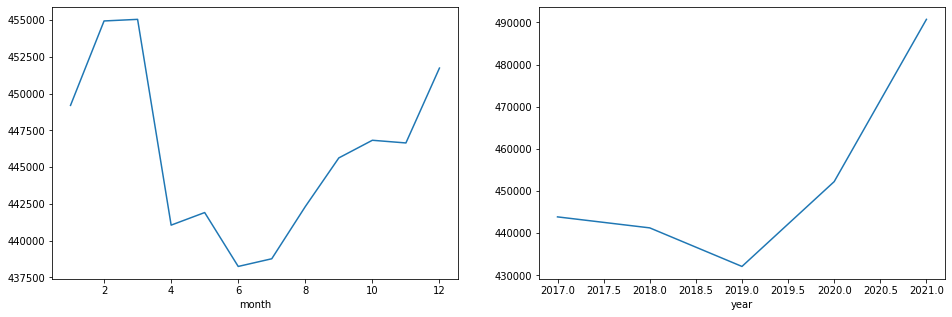

In [8]:
#let's break date to years, months
dataframe['date'] = pd.to_datetime(dataframe['month'])
dataframe['month'] = dataframe['date'].apply(lambda date:date.month)
dataframe['year'] = dataframe['date'].apply(lambda date:date.year)

#Get number of years left on lease as a continuous number (ignoring months)
dataframe['remaining_lease'] = dataframe['remaining_lease'].apply(lambda remaining_lease:remaining_lease[:2])

#Get storey range as a continuous number
dataframe['storey_range'] = dataframe['storey_range'].apply(lambda storey_range:storey_range[:2])

#data visualization house price vs months and years
fig = plt.figure(figsize=(16,5))
fig.add_subplot(1,2,1)
dataframe.groupby('month').mean()['resale_price'].plot()
fig.add_subplot(1,2,2)
dataframe.groupby('year').mean()['resale_price'].plot()


We can also use Google Geocode rest API to enrich the dataframe with longtitude and latitude data. For example,
import requests

response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address=1600+Amphitheatre+Parkway,+Mountain+View,+CA')

resp_json_payload = response.json()

print(resp_json_payload['results'][0]['geometry']['location'])

OR

USe Geopy and Geopanda as shown here https://towardsdatascience.com/geocode-with-python-161ec1e62b89

In [9]:
%pip install geopandas
%pip install geopy

     |████████████████████████████████| 1.0MB 9.3MB/s 
     |████████████████████████████████| 6.5MB 10.9MB/s 
     |████████████████████████████████| 14.8MB 189kB/s 


# Geocode locations

In [10]:
#Concat address

dataframe['address'] = dataframe['block'].map(str) + ', ' + dataframe['street_name'].map(str) + ', Singapore' 

In [11]:

import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
import folium
from folium.plugins import FastMarkerCluster
from geopy.extra.rate_limiter import RateLimiter

'''
#Geocode by address
locator = Nominatim(user_agent="myGeocoder")

# 1 - convenient function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
dataframe['location'] = dataframe['address'].apply(geocode)
print("step 2")
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
dataframe['point'] = dataframe['location'].apply(lambda loc: tuple(loc.point) if loc else None)
print("step 3")
# 4 - split point column into latitude, longitude and altitude columns
dataframe[['latitude', 'longitude', 'altitude']] = pd.DataFrame(dataframe['point'].tolist(), index=df.index)
print("step 4")
'''
#Geocode by town (Singapore is so small that geocoding by addresses might not make much difference compared to geocoding to town)
town = [x for x in dataframe['town'].unique().tolist() 
            if type(x) == str]
latitude = []
longitude =  []
for i in range(0, len(town)):
    # remove things that does not seem usefull here
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        loc = geolocator.geocode(town[i])
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
        print('The geographical coordinate of location are {}, {}.'.format(loc.latitude, loc.longitude))
    except:
        # in the case the geolocator does not work, then add nan element to list
        # to keep the right size
        latitude.append(np.nan)
        longitude.append(np.nan)
# create a dataframe with the locatio, latitude and longitude
df_ = pd.DataFrame({'town':town, 
                    'latitude': latitude,
                    'longitude':longitude})
# merge on Restaurant_Location with rest_df to get the column 
dataframe = dataframe.merge(df_, on='town', how='left')


The geographical coordinate of location are 1.3700803, 103.8495228.
The geographical coordinate of location are 1.3239765, 103.930216.
The geographical coordinate of location are 1.3509859, 103.84825507492937.
The geographical coordinate of location are 1.3490572, 103.7495906.
The geographical coordinate of location are 6.2102098, 100.7640922.
The geographical coordinate of location are 1.3791486, 103.76141301431002.
The geographical coordinate of location are 1.3546901, 103.7763724.
The geographical coordinate of location are 36.5070827, -79.7447575.
The geographical coordinate of location are 1.3847493, 103.7445341.
The geographical coordinate of location are 1.3151003, 103.7652311.
The geographical coordinate of location are 1.3181862, 103.8870563.
The geographical coordinate of location are 1.3708011, 103.89254433997465.
The geographical coordinate of location are 1.333108, 103.7422939.
The geographical coordinate of location are 1.3396365, 103.7073387.
The geographical coordinate 

In [12]:
dataframe.head(100)

month        town  ...  latitude   longitude
0       1  ANG MO KIO  ...  1.370080  103.849523
1       1  ANG MO KIO  ...  1.370080  103.849523
2       1  ANG MO KIO  ...  1.370080  103.849523
3       1  ANG MO KIO  ...  1.370080  103.849523
4       1  ANG MO KIO  ...  1.370080  103.849523
..    ...         ...  ...       ...         ...
95      1       BEDOK  ...  1.323976  103.930216
96      1       BEDOK  ...  1.323976  103.930216
97      1       BEDOK  ...  1.323976  103.930216
98      1       BEDOK  ...  1.323976  103.930216
99      1       BEDOK  ...  1.323976  103.930216

[100 rows x 16 columns]

In [13]:
folium_map = folium.Map(location=[1.3521,103.8198],
                        zoom_start=12,
                        tiles='CartoDB dark_matter')


FastMarkerCluster(data=list(zip(dataframe['latitude'].values, dataframe['longitude'].values))).add_to(folium_map)
folium.LayerControl().add_to(folium_map)
folium_map

In [14]:
# check if there are any Null values
dataframe.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
date                   0
year                   0
address                0
latitude               0
longitude              0
dtype: int64

# Encode categorical string values

In [15]:
### label encode the categorical values and convert them to numbers 
'''
le = LabelEncoder()

dataframe['town']= le.fit_transform(dataframe['town'].astype(str))

dataframe['flat_type'] = le.fit_transform(dataframe['flat_type'].astype(str))

dataframe['street_name'] = le.fit_transform(dataframe['street_name'].astype(str))

#dataframe['storey_range'] = le.fit_transform(dataframe['storey_range'].astype(str))

dataframe['flat_model'] = le.fit_transform(dataframe['flat_model'].astype(str))

dataframe['block'] = le.fit_transform(dataframe['block'].astype(str))

dataframe['address'] = le.fit_transform(dataframe['address'].astype(str))
'''

townDict = {'ANG MO KIO': 1,'BEDOK': 2,'BISHAN': 3,'BUKIT BATOK': 4,'BUKIT MERAH': 5,'BUKIT PANJANG': 6,'BUKIT TIMAH': 7,'CENTRAL AREA': 8,'CHOA CHU KANG': 9,'CLEMENTI': 10,'GEYLANG': 11,'HOUGANG': 12,'JURONG EAST': 13,'JURONG WEST': 14,'KALLANG/WHAMPOA': 15,'MARINE PARADE': 16,'PASIR RIS': 17,'PUNGGOL': 18,'QUEENSTOWN': 19,'SEMBAWANG': 20,'SENGKANG': 21,'SERANGOON': 22,'TAMPINES': 23,'TOA PAYOH': 24,'WOODLANDS': 25,'YISHUN': 26,}
flat_typeDict = {'1 ROOM': 1,'2 ROOM': 2,'3 ROOM': 3,'4 ROOM': 4,'5 ROOM': 5,'EXECUTIVE': 6,'MULTI-GENERATION': 7,}


dataframe['town'] = dataframe['town'].replace(townDict, regex=True)
dataframe['flat_type'] = dataframe['flat_type'].replace(flat_typeDict, regex=True)



# Understand correlations

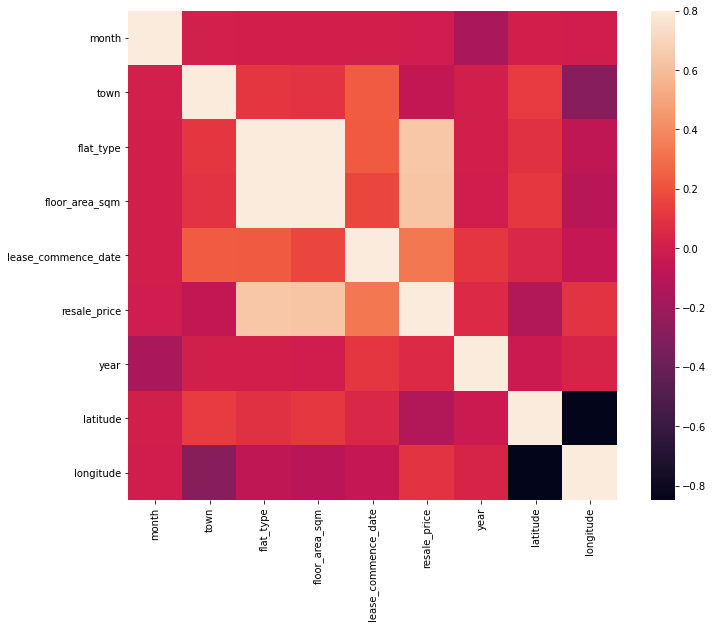

In [16]:
#correlation matrix
corrmat = dataframe.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

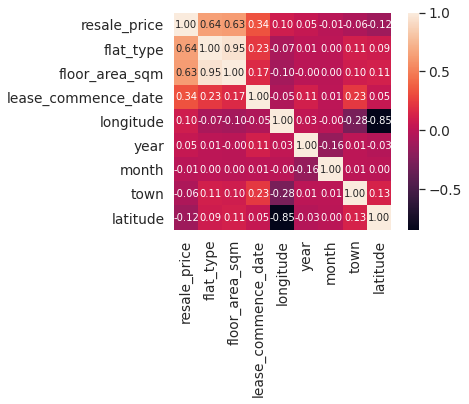

In [17]:
#resale_price correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'resale_price')['resale_price'].index
cm = np.corrcoef(dataframe[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Drop columns with low correlations

In [18]:


# drop some unnecessary columns
dataframe = dataframe.drop('date',axis=1)

dataframe = dataframe.drop('block',axis=1)
#dataframe = dataframe.drop('lease_commence_date',axis=1)
dataframe = dataframe.drop('month',axis=1)
dataframe = dataframe.drop('street_name',axis=1)
dataframe = dataframe.drop('address',axis=1)
dataframe = dataframe.drop('flat_model',axis=1)
#dataframe = dataframe.drop('town',axis=1)
dataframe = dataframe.drop('year',axis=1)
#dataframe = dataframe.drop('latitude',axis=1)
dataframe = dataframe.drop('remaining_lease',axis=1)








# Preview model input data

In [19]:
dataframe.head()

town  flat_type storey_range  ...  resale_price  latitude   longitude
0     1          2           10  ...      232000.0   1.37008  103.849523
1     1          3           01  ...      250000.0   1.37008  103.849523
2     1          3           01  ...      262000.0   1.37008  103.849523
3     1          3           04  ...      265000.0   1.37008  103.849523
4     1          3           01  ...      265000.0   1.37008  103.849523

[5 rows x 8 columns]

# Data Split

In [20]:
#X = dataframe.drop('resale_price',axis =1).values
#y = dataframe['resale_price'].values

X = dataframe.drop('resale_price',axis =1)
y = dataframe['resale_price']



In [21]:
X=X.values
y=y.values

In [22]:
print(X[0])

[1 2 '10' 44.0 1979 1.3700803 103.8495228]


In [23]:
#splitting Train and Test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [24]:
print(X_train[0])

[13 3 '25' 72.0 2013 1.333108 103.7422939]


# Scaling

In [25]:
#standardization scaler - fit&transform on train, fit only on test

s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float))


#MinMax scaler - fit&transform on train, fit only on test
'''
s_scaler = MinMaxScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float))
'''

'\ns_scaler = MinMaxScaler()\nX_train = s_scaler.fit_transform(X_train.astype(np.float))\nX_test = s_scaler.transform(X_test.astype(np.float))\n'

# Model 1: Linear Regression

In [26]:
# Multiple Liner Regression
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
#evaluate the model (intercept and slope)
print(regressor.intercept_)
print(regressor.coef_)
#predicting the test set result
y_pred = regressor.predict(X_test)
#put results as a DataFrame
coeff_df = pd.DataFrame(regressor.coef_, dataframe.drop('resale_price',axis =1).columns, columns=['Coefficient']) 
coeff_df

445987.4539708216
[-23444.75893564  26113.3156362   43905.21203965  73360.36750091
  27692.82182292 -35036.62958465 -13475.73696025]


Coefficient
town                -23444.758936
flat_type            26113.315636
storey_range         43905.212040
floor_area_sqm       73360.367501
lease_commence_date  27692.821823
latitude            -35036.629585
longitude           -13475.736960

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


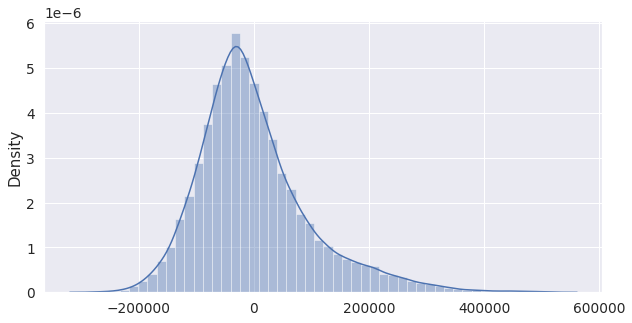

In [27]:
# visualizing residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test- y_pred)
sns.distplot(residuals)

In [28]:
#compare actual output values with predicted values
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(10)
df1


Actual      Predicted
0  315000.0  299385.625855
1  610888.0  444598.540325
2  390000.0  385299.665849
3  405000.0  556781.083200
4  600000.0  545184.551109
5  395000.0  456648.492463
6  585000.0  472193.489160
7  448000.0  283516.811997
8  250000.0  318282.041389
9  698000.0  655909.180326

In [29]:
print(y_test)

[315000. 610888. 390000. ... 360000. 330888. 312000.]


In [30]:
# evaluate the performance of the algorithm (MAE - MSE - RMSE)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))

MAE: 73535.29651994556
MSE: 9733932313.141926
RMSE: 98660.69284746549
VarScore: 0.5975958635727545


# Model 2: Keras neural network

In [31]:
# Creating a Neural Network Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.optimizers import Adam

In [32]:
# having 7 neuron is based on the number of available features
model = Sequential()
model.add(Dense(9,activation='relu'))
model.add(Dense(18,activation='relu'))
model.add(Dense(18,activation='relu'))
model.add(Dense(9,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam',loss='mse')

In [33]:
model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=128,epochs=400)

model.summary()

Epoch 1/400
519/519 [==============================] - 2s 2ms/step - loss: 221726945500.5538 - val_loss: 174269431808.0000
Epoch 2/400
519/519 [==============================] - 1s 2ms/step - loss: 111384185824.4923 - val_loss: 15877572608.0000
Epoch 3/400
519/519 [==============================] - 1s 2ms/step - loss: 14499502528.9846 - val_loss: 12490395648.0000
Epoch 4/400
519/519 [==============================] - 1s 2ms/step - loss: 11979478291.6923 - val_loss: 11014639616.0000
Epoch 5/400
519/519 [==============================] - 1s 2ms/step - loss: 10648407906.4615 - val_loss: 10134071296.0000
Epoch 6/400
519/519 [==============================] - 1s 2ms/step - loss: 9886064063.0154 - val_loss: 9595711488.0000
Epoch 7/400
519/519 [==============================] - 1s 2ms/step - loss: 9304140357.9077 - val_loss: 9244385280.0000
Epoch 8/400
519/519 [==============================] - 1s 2ms/step - loss: 9034915794.7077 - val_loss: 8985391104.0000
Epoch 9/400
519/519 [==============

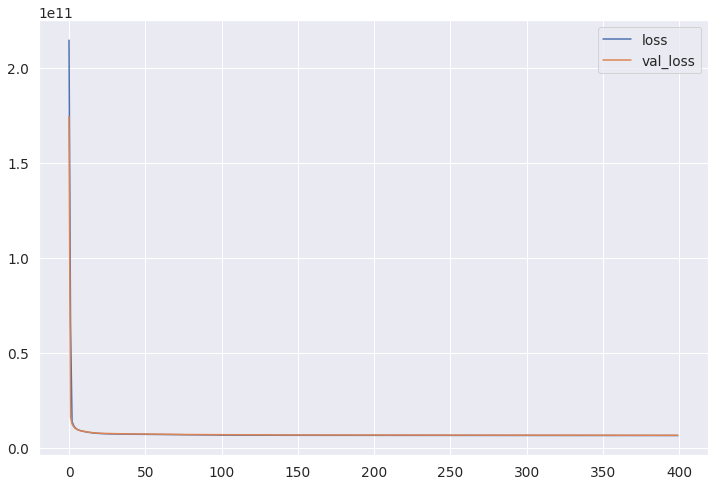

In [34]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize=(12,8))

MAE: 57137.28597243686
MSE: 6447987245.939036
RMSE: 80299.36018387093
VarScore: 0.7334634885123807


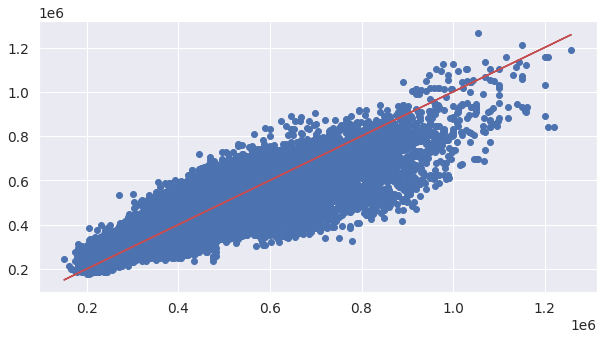

In [35]:
y_pred = model.predict(X_test)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)
# Perfect predictions
plt.plot(y_test,y_test,'r')

In [36]:
# visualizing residuals
'''
fig = plt.figure(figsize=(10,5))
residuals = (y_test- y_pred)
sns.distplot(residuals)
'''

'\nfig = plt.figure(figsize=(10,5))\nresiduals = (y_test- y_pred)\nsns.distplot(residuals)\n'

In [37]:
print(y_pred)

[[305195.2 ]
 [386971.84]
 [453860.56]
 ...
 [390154.9 ]
 [353715.5 ]
 [415141.78]]


In [38]:
y_pred_2 = []
for pred in y_pred:
  y_pred_2.append(pred[0])

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_2})
df1 = df.head(20)
df1

Actual     Predicted
0   315000.0  305195.18750
1   610888.0  386971.84375
2   390000.0  453860.56250
3   405000.0  538819.75000
4   600000.0  493325.21875
5   395000.0  393131.31250
6   585000.0  437100.18750
7   448000.0  318911.75000
8   250000.0  261410.40625
9   698000.0  650111.87500
10  285000.0  310935.43750
11  380500.0  292981.56250
12  405000.0  421497.75000
13  310000.0  392223.34375
14  360000.0  434734.15625
15  490000.0  498481.78125
16  216000.0  185779.71875
17  320000.0  368131.93750
18  319000.0  338491.21875
19  276000.0  316202.68750

# Model 3: K nearest neighbours



We would like to try K nearest neighbours to try to improve our pricing accuracy. We use scikit learn, with reference to this example https://www.dataquest.io/blog/machine-learning-tutorial/

In [39]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(algorithm='brute')

In [40]:
knn.fit(X_train,y_train)

KNeighborsRegressor(algorithm='brute', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [41]:
print(X_test[0])

[-1.62362671 -1.23166716 -1.14462313 -0.89698225 -1.33633234 -0.11481853
  0.2569525 ]


In [42]:
predictions = knn.predict(X_test)


In [43]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
rmse = mse ** (1/2)
print(rmse)

45785.29517905796


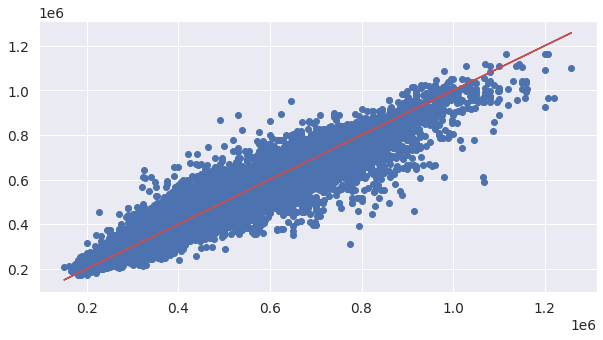

In [44]:
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,predictions)
# Perfect predictions
plt.plot(y_test,y_test,'r')

In [45]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
df1 = df.head(20)
df1

Actual  Predicted
0   315000.0   316000.0
1   610888.0   479800.0
2   390000.0   358700.0
3   405000.0   471000.0
4   600000.0   586000.0
5   395000.0   413160.0
6   585000.0   535400.0
7   448000.0   323600.0
8   250000.0   247000.0
9   698000.0   660600.0
10  285000.0   294000.0
11  380500.0   316800.0
12  405000.0   365160.0
13  310000.0   348000.0
14  360000.0   381177.6
15  490000.0   532777.6
16  216000.0   226560.0
17  320000.0   302000.0
18  319000.0   321600.0
19  276000.0   267400.0

# Conclusion

K nearest neighbours seems to have the best prediction with a relatively low RMSE. Neural networks come in second while Linear regression comes in last.